# Set-up

In [1]:
import sys
import torch

print(f"Python executable: {sys.executable}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Python executable: /home/prashant/repo/public/sam3-cpu/.venv/bin/python
CUDA available: False


In [2]:
import os
import sam3

sam3_root = os.path.join(os.path.dirname(sam3.__file__))
device = "cuda" if torch.cuda.is_available() else "cpu"

INFO 2026-02-18 11:31:29,046 2840635 __globals.py:  11: Python executable: /home/prashant/repo/public/sam3-cpu/.venv/bin/python
INFO 2026-02-18 11:31:29,046 2840635 __globals.py:  12: CUDA available: False
INFO 2026-02-18 11:31:29,047 2840635 __globals.py:  24: ⚡ Profiling DISABLED (use --profile to enable)



In [3]:
bpe_path = os.path.join(sam3_root, "assets/bpe_simple_vocab_16e6.txt.gz")
num_workers = 1 if device == "cpu" else 0
if device == "cpu":
    from sam3.model_builder import build_sam3_video_predictor_cpu
    print("Running on CPU. For better performance, please run on a GPU.")
    predictor = build_sam3_video_predictor_cpu(bpe_path=bpe_path, num_workers=num_workers)
else:
    from sam3.model_builder import build_sam3_video_predictor
    print("Running on GPU")
    predictor = build_sam3_video_predictor()

INFO 2026-02-18 11:31:31,697 2840635 sam3_video_predictor_v2.py: 552: using 1 CPU workers for parallel inference
INFO 2026-02-18 11:31:31,698 2840635 sam3_video_predictor_v2.py: 567: 


	*** START loading model on all ranks ***


INFO 2026-02-18 11:31:31,699 2840635 sam3_video_predictor_v2.py: 569: loading model on rank=0 with world_size=1 -- this could take a while ...


Running on CPU. For better performance, please run on a GPU.


INFO 2026-02-18 11:31:36,720 2840635 sam3_video_base.py: 125: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2026-02-18 11:31:38,193 2840635 sam3_video_predictor_v2.py: 573: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2026-02-18 11:31:38,193 2840635 sam3_video_predictor_v2.py: 583: 


	*** DONE loading model on all ranks ***




# Inference and visualisation Utils

In [4]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sam3.visualization_utils import (
    load_frame,
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
)

# font size for axes titles
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12


def propagate_in_video(predictor, session_id):
    # we will just propagate from frame 0 to the end of the video
    outputs_per_frame = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
            start_frame_index=0,
            max_frame_num_to_track=30
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]

    return outputs_per_frame


def abs_to_rel_coords(coords, IMG_WIDTH, IMG_HEIGHT, coord_type="point"):
    """Convert absolute coordinates to relative coordinates (0-1 range)

    Args:
        coords: List of coordinates
        coord_type: 'point' for [x, y] or 'box' for [x, y, w, h]
    """
    if coord_type == "point":
        return [[x / IMG_WIDTH, y / IMG_HEIGHT] for x, y in coords]
    elif coord_type == "box":
        return [
            [x / IMG_WIDTH, y / IMG_HEIGHT, w / IMG_WIDTH, h / IMG_HEIGHT]
            for x, y, w, h in coords
        ]
    else:
        raise ValueError(f"Unknown coord_type: {coord_type}")

# Loading an example video

In [5]:
# video_path = os.path.join(sam3_root, "../assets/videos/bedroom.mp4")
video_path = os.path.join(sam3_root, "../assets/videos/bedroom.mp4")

In [6]:
# load "video_frames_for_vis" for visualization purposes (they are not used by the model)
if isinstance(video_path, str) and video_path.endswith(".mp4"):
    cap = cv2.VideoCapture(video_path)
    video_frames_for_vis = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        video_frames_for_vis.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
else:
    video_frames_for_vis = glob.glob(os.path.join(video_path, "*.jpg"))
    try:
        # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
        video_frames_for_vis.sort(
            key=lambda p: int(os.path.splitext(os.path.basename(p))[0])
        )
    except ValueError:
        # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
        print(
            f'frame names are not in "<frame_index>.jpg" format: {video_frames_for_vis[:5]=}, '
            f"falling back to lexicographic sort."
        )
        video_frames_for_vis.sort()

# Opening an inference session on this video

In [7]:
response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_path,
    )
)
session_id = response["session_id"]

frame loading (OpenCV) [rank=0]: 100%|██████████| 200/200 [00:00<00:00, 1079.54it/s]


## Video promptable concept segmentation with text

In [8]:
# note: in case you already ran one text prompt and now want to switch to another text prompt
# it's required to reset the session first (otherwise the results would be wrong)
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

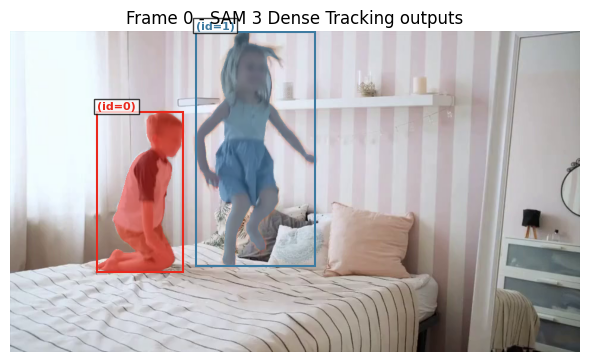

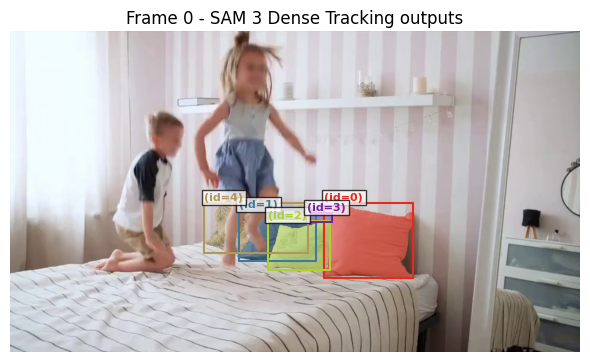

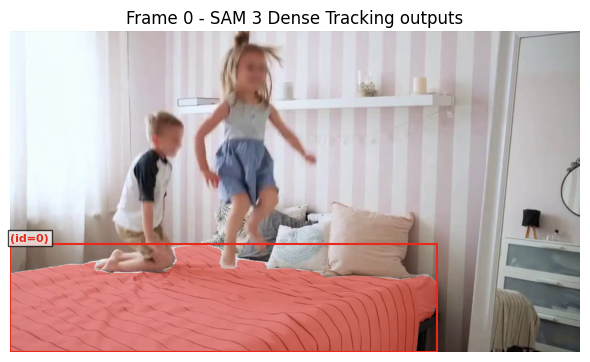

In [ ]:
# prompt_text_str = "player holding a tennis racket"  # this is the text prompt we want to add on frame 0
prompt_text_str = "kids"
# prompts = ["player holding a tennis racket", "tennis racket", "ball"]  # you can also specify multiple prompts at once
frame_idx = 0  # add a text prompt on frame 0
response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
    )
)
out = response["outputs"]

plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

propagate_in_video:   0%|          | 0/31 [00:00<?, ?it/s]

0it [00:00, ?it/s]

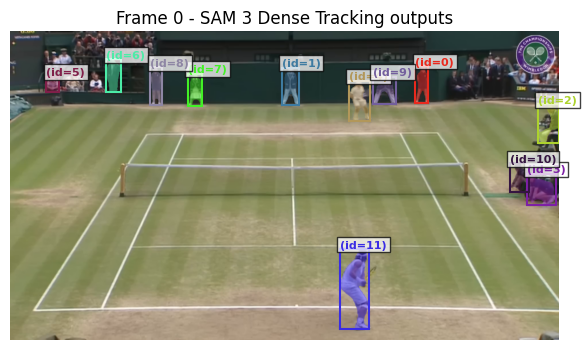

In [12]:
# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(predictor, session_id)

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

## Removing objects

In [11]:
# we pick id 1, which is the girl
obj_id = 1
response = predictor.handle_request(
    request=dict(
        type="remove_object",
        session_id=session_id,
        obj_id=obj_id,
    )
)

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

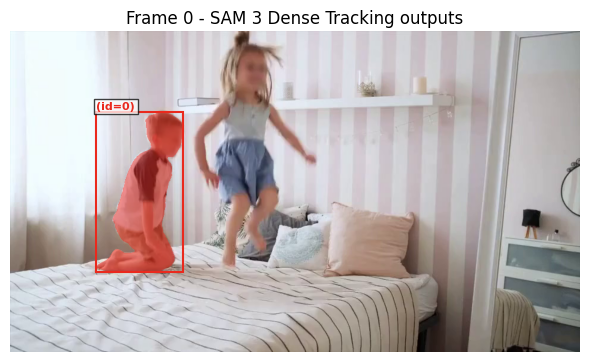

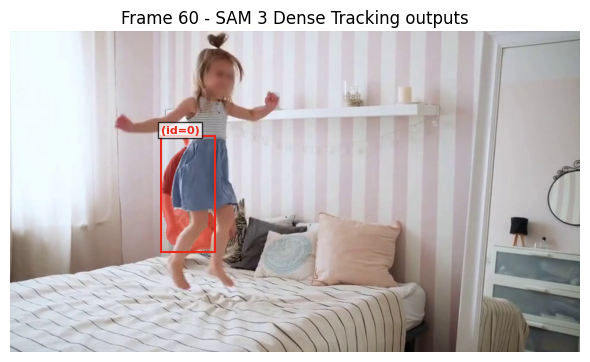

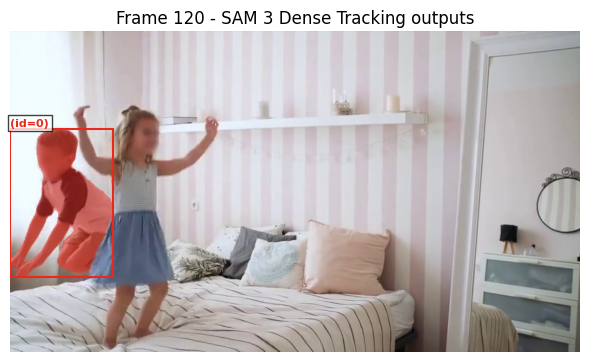

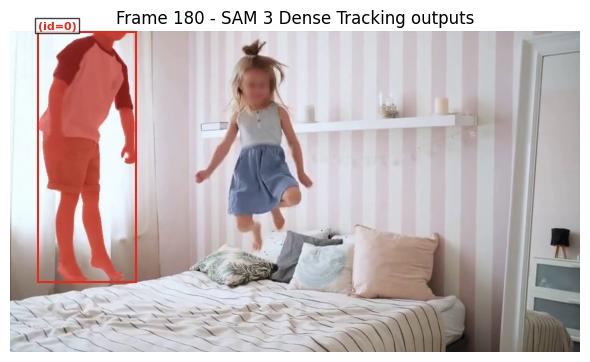

In [12]:
# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(predictor, session_id)

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

## Adding new objects with point prompts

In [13]:
sample_img = Image.fromarray(load_frame(video_frames_for_vis[0]))

IMG_WIDTH, IMG_HEIGHT = sample_img.size

In [20]:
# let's add back the dancer via point prompts.
# we will use a single positive click to add the dancer back.

frame_idx = 0
obj_id = 2
points_abs = np.array(
    [
        [620, 360],  # positive click
    ]
)
# positive clicks have label 1, while negative clicks have label 0
labels = np.array([1])

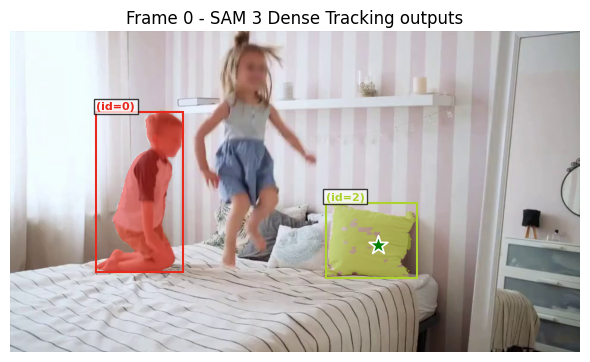

In [21]:
# convert points and labels to tensors; also convert to relative coordinates
points_tensor = torch.tensor(
    abs_to_rel_coords(points_abs, IMG_WIDTH, IMG_HEIGHT, coord_type="point"),
    dtype=torch.float32,
)
points_labels_tensor = torch.tensor(labels, dtype=torch.int32)

response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        points=points_tensor,
        point_labels=points_labels_tensor,
        obj_id=obj_id,
    )
)
out = response["outputs"]

plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
    points_list=[points_abs],
    points_labels_list=[labels],
)

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

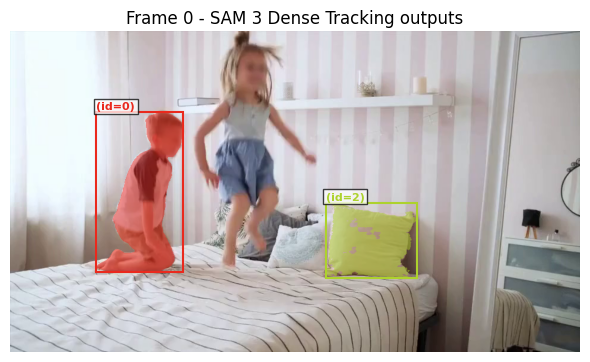

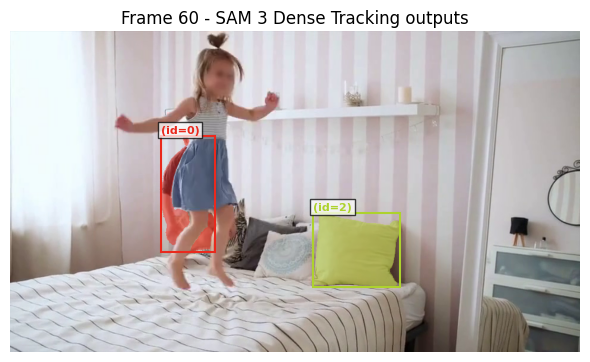

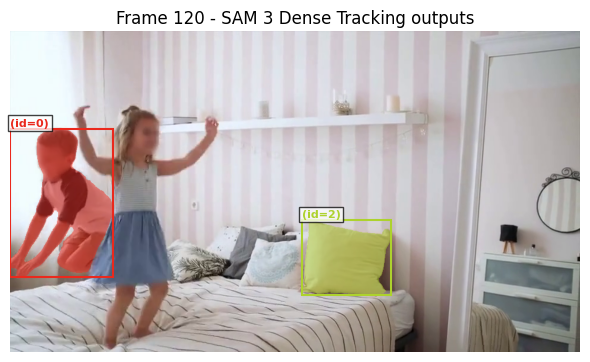

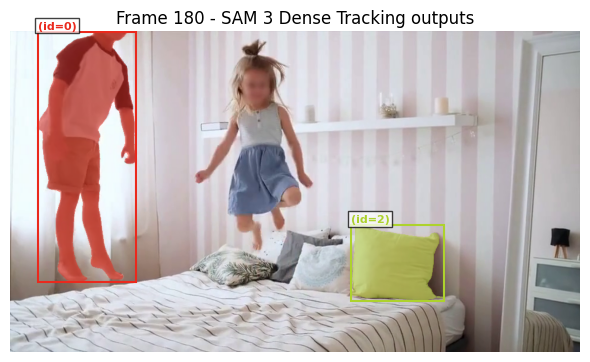

In [22]:
# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(predictor, session_id)

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

## Refining an existing object with point prompts

In [27]:
# For the dancer in the front, suppose now we only want to segment her T-shirt instead of her whole body
# we will use 2 positive clicks and 2 negative clicks to select her shirt.

frame_idx = 0
obj_id = 1
points_abs = np.array(
    [
        [440, 260],  # positive click
        # [760, 630],  # negative click
        # [840, 640],  # negative click
        # [760, 550],  # positive click
    ]
)
# positive clicks have label 1, while negative clicks have label 0
labels = np.array([1]) #, 0, 0, 1])

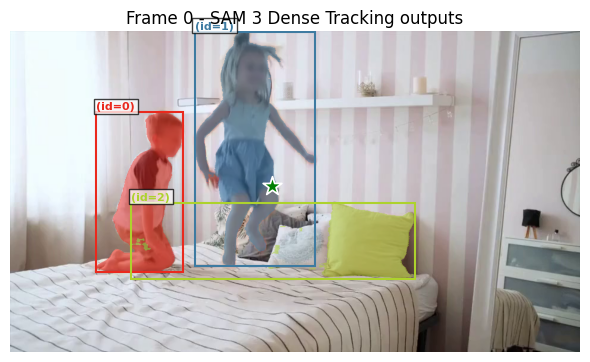

In [28]:
# convert points and labels to tensors; also convert to relative coordinates
points_tensor = torch.tensor(
    abs_to_rel_coords(points_abs, IMG_WIDTH, IMG_HEIGHT, coord_type="point"),
    dtype=torch.float32,
)
points_labels_tensor = torch.tensor(labels, dtype=torch.int32)

response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        points=points_tensor,
        point_labels=points_labels_tensor,
        obj_id=obj_id,
    )
)
out = response["outputs"]

plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
    points_list=[points_abs],
    points_labels_list=[labels],
)

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

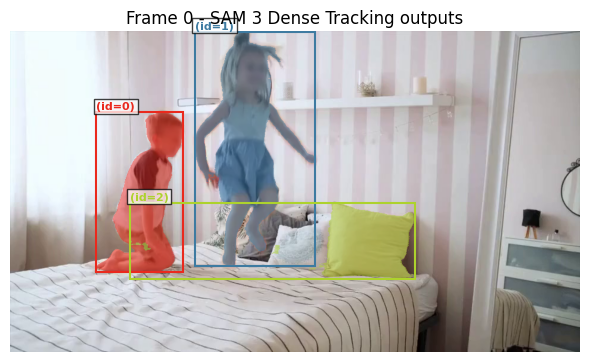

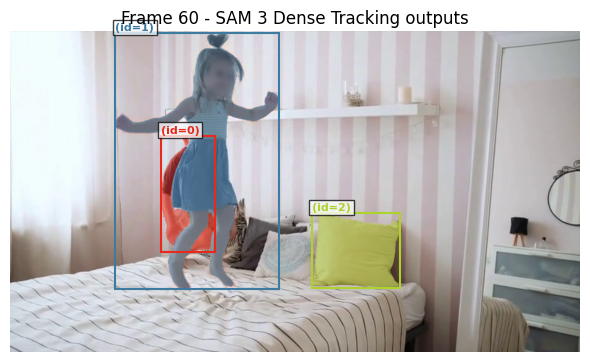

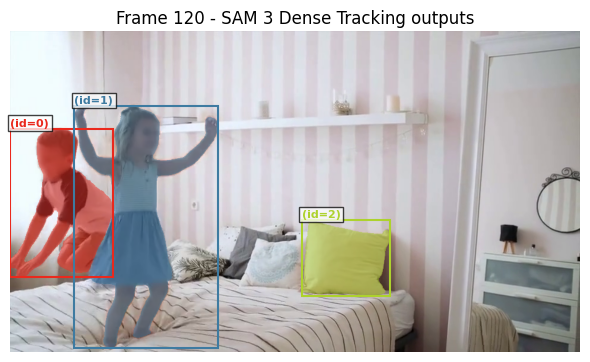

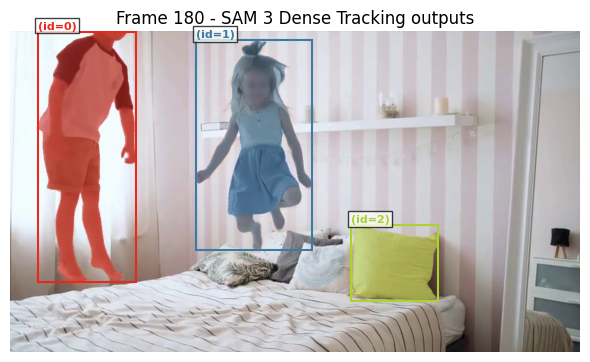

In [29]:
# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(predictor, session_id)

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

## Close Session

In [30]:
# finally, close the inference session to free its GPU resources
# (you may start a new session on another video)
_ = predictor.handle_request(
    request=dict(
        type="close_session",
        session_id=session_id,
    )
)

INFO 2026-02-12 14:17:19,506 1387526 sam3_video_predictor_v2.py: 252: removed session f0f4e8b6-7ceb-4a1c-86fd-ea04ee6117bc; live sessions: [], CPU memory: 8736 MiB used


## Clean-up

In [9]:
# after all inference is done, we can shutdown the predictor
# to free up the multi-GPU process group
predictor.shutdown()

NameError: name 'predictor' is not defined

In [10]:
# Free Torch memory from CPU and GPU
if device == "cuda":
    torch.cuda.empty_cache()
elif device == "cpu": # Free memory on CPU - Works only on Linux
    import ctypes
    import gc

    if 'predictor' in locals(): 
        del predictor
    if 'response' in locals(): 
        del response
    if 'video_frames_for_vis' in locals(): 
        del video_frames_for_vis
    if 'outputs_per_frame' in locals(): 
        del outputs_per_frame

    libc = ctypes.CDLL("libc.so.6")
    libc.malloc_trim(0)

    gc.collect()